## Traing and inference
  - IV: prediction
  - V: plotting
  - VI: Generate the probability density and entropy data by various augmentation factors
  
  


## I. Import data

In [1]:
###### prediction with student life dataset sliced #############

import numpy as np
import pandas as pd
import random
dir_data = '../data/processed_data/'


In [2]:
##########  0. import phq/label and ema/sensing data #######################
## select user with 'post' score available 

phq = pd.read_csv(dir_data+ 'phq9_score.csv')  # shape of 84,15
phq = phq.loc[phq['type']=='post']
phq=(phq.loc[:,['uid','type','depression severity','phq score','dp_grade', 'dp_class']]).set_index('uid')
phq.rename_axis('user', inplace=True)  # change index from 'uid' to 'user'

print("PHQ-9 shape, with selected user (post): ", phq.shape)

## import EMA/sensing data
dataset = pd.read_csv(dir_data+'studentlife_data_full.csv', index_col=0)#set the col0 as index, index as "u00_2013-03-24"

print ('Dataset shape :',dataset.shape)
# dataset

PHQ-9 shape, with selected user (post):  (38, 5)
Dataset shape : (3407, 87)


## II. Build model and functions

In [3]:
################## 2. build model ##########################
from abc import ABC, abstractmethod
from keras.models import Sequential
from keras import backend as K
from keras import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import SimpleRNN, LSTM, Embedding, Dense, Dropout, BatchNormalization,LeakyReLU, MaxPooling2D, Conv2D,Flatten
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,  accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib import dates as mdates


class BaseModel(ABC):
    """ Super class for Machine Learning Class"""
    
    @abstractmethod
    def train_predict(self):
        pass
    
    @abstractmethod
    def predict(self):
        pass
        
    def load_predict(self, X, predict_type):
        pass
    
    def accuracy(self, predict, label):
        predict = predict.ravel()
        label = label.ravel()
        return np.sum(predict == label)/len(label) 

class RNN_model(BaseModel):
    def __init__(self, win_width, feature_num, epochs):
        self.epochs = epochs
        self.model = Sequential()
        self.model.add(SimpleRNN(units=128, input_shape=(win_width, feature_num),activation="relu")) 
        self.model.add(BatchNormalization())
        
        self.model.add(Dense(units=64, activation="relu")) 
        self.model.add(BatchNormalization())
        
        self.model.add(Dense(units=32, activation="relu")) 
        self.model.add(BatchNormalization())
        
        self.model.add(Dense(units= 2, activation="linear")) # 
        self.model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc']) 
        self.model.summary()  
      
        
    def train_predict(self, X, y,X_test, predict_type):
        print('On training...')
#         history = self.model.fit(X,y,batch_size=30,epochs=self.epochs, verbose = 0) 
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000) # to set patience
        history=self.model.fit(X,y,batch_size=128,validation_split=0.33, epochs= self.epochs, verbose = 0, callbacks=[es]) 
#         history=self.model.fit(X,y,batch_size=128,validation_split=0.33, epochs= self.epochs, verbose = 0) 
#         self.model.save(save_dir+'RNN_'+predict_type+'.h5')
        print('Training done !')
        return self.model.predict(X_test), history
    
    def predict(self, X):
        return self.model.predict(X)
    
    def load_predict(self, X, predict_type):
        try:
            self.model.load_weights('RNN_'+predict_type+'.h5')
        except IOError:
            raise Exception('IoError when reading dayline data file: ' + 'RNN_model.h5')
            
class LSTM_model(BaseModel):
    def __init__(self, win_width, feature_num, epochs):
        self.epochs= epochs
        self.model = Sequential()
        self.model.add(LSTM(units=128, input_shape=(win_width, feature_num), activation='relu', return_sequences= True))  # input_shape=(timesteps ,data_dim)
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.05))  # to set dropout rate
        self.model.add(LSTM(units = 64, activation='relu', return_sequences= True, return_state= False))
        self.model.add(BatchNormalization())
        self.model.add(LSTM(units = 32, activation='relu', return_sequences= False, return_state= False))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.05)) # to set dropout rate

        self.model.add(Dense(units = 2, activation = "relu"))
#         self.model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
        self.model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc']) 
       
    
    def train_predict(self, X, y, X_test,predict_type):
        self.model.summary()
        print('On training...')

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1200) # to set patience
        history=self.model.fit(X,y,batch_size=128,validation_split=0.33, epochs= self.epochs, verbose = 0, callbacks=[es]) 
#         history=self.model.fit(X,y,batch_size=128,validation_split=0.33, epochs= self.epochs, verbose = 0) 

        #         self.model.save(save_dir+'LSTM_'+predict_type+'.h5')
        print('Training done !')
        return self.model.predict(X_test), history
   
    def predict(self, X):
        return self.model.predict(X)
    
    def load_predict(self, X, predict_type):
        try:
            self.model.load_weights('LSTM_'+predict_type+'.h5')
        except IOError:
             raise Exception('IoError when reading dayline data file: ' + 'LSTM_model.h5')
        return self.model.predict(X)
   
  
def accuracy(predict, label):
    predict = predict.ravel()
    label = label.ravel()
    return np.sum(predict == label)/len(label) 



In [4]:
################## functions: data processing #####################
########################################################

def dataExtract(data, win_width =10, stride =1, forward_step= 0, label = 'label', normalize = False): # output 3 dimensions array
    sample_num = data.shape[0]

    y=data.loc[:,label].values
    X = data.drop(columns = [label]) # drop 'label column, use remain for feature
    feature_num = X.shape[1]
    if normalize == True:
        X = minmaxNormalize(X)
#         X = Normalize(X)
    X_new = np.array([[]]*feature_num).T.reshape(0,win_width,feature_num) # 3D empty array
    y_new = []
    for i in range(sample_num-forward_step,0, -stride):
        X_win = X.values[i-win_width:i,:] 
        if X_win.shape[0] <win_width:
            break 
        X_win = X_win.reshape(1,win_width,feature_num) # reshape to 3D for catanecating
        X_new = np.vstack((X_new,X_win)) 
        y_new.append(y[i+forward_step-1]) 
    X_new = X_new[::-1,:,:] 
    y_new = np.array(y_new[::-1]) 
    return X_new, y_new # retrun array instead of dataframe

def minmaxNormalize(X, axis = 0): # default axis set to 0
    minum = np.min(X, axis = axis)
    maxum = np.max(X, axis = axis)
    return (X-minum)/(maxum-minum)

def Normalize(X):
    return  X/np.linalg.norm(X, ord = 2, axis = 0)

def PCA(X, k, axis=1):  # feature in rows axis =0, in cols axis =1, X in np.array formate
    if axis==0:  #features by rows
        n = X.shape[0]
        mean = np.mean(X, axis = 0).reshape(1,-1) # features number X data number 
        Xm = (X- mean)
        COV =  Xm @ Xm.T/(n-1)
        eig_value, eig_vector = np.linalg.eig(COV) 
        index = np.argsort(-1*eig_value) # rank from the largest value to the smallest one， descend
        P = eig_vector[:,index[0:k]]
        return P.T @ Xm
    else:  #axis == 1, features by cols
#         X=dataframe.values
        n = np.array(X).shape[1]
        mean = np.mean(X, axis = 1).reshape(-1,1) # features number X data number 
        Xm = (X- mean)
        COV =  Xm.T@Xm/(n-1)
        eig_value, eig_vector = np.linalg.eig(COV) 
        index = np.argsort(-1*eig_value) # rank from the largest value to the smallest one， descend
        P = eig_vector[:,index[0:k]]
        return Xm@P
    

def slice_sum_by_id(data,id_list, win_width, stride, forward_step, label):
    x_f=np.array([])
    y_f=np.array([])
#     id_list =np.unique(data['ID'])
    for id in id_list:
        #data_id= (data.where(data['ID']==id)).dropna()
        data_id= data[data.index==id]
        x_sliced, y_sliced = dataExtract(data_id, win_width =win_width, stride =stride, \
                                         forward_step= forward_step, label = label, normalize = False)
        if not x_f.any():  # initialize 3d array
            x_f=np.empty(shape=x_sliced.shape)  #sliced size for each id =90-(win_width+stride+forward_step)+2
            y_f=np.empty(shape=y_sliced.shape)
            init=x_sliced.shape[0]
        x_f= np.append(x_f,x_sliced, axis=0)
        y_f= np.append(y_f,y_sliced, axis=0)
    x_f=x_f[init:,:,:]  # take off the first chunk created by np.empty : size of init
    y_f=y_f[init:,]
    return x_f, y_f

''' create a diction of score:grade '''
dp_grade ={0:[0,4], 1:[5,9],2:[10,14],3:[15,19],4:[20,27]} 
dp_score2grade={}
for key, value in dp_grade.items(): 
    for i in range(value[0], value[1]+1):
        dp_score2grade[i]=key
        
# normalize dataset and fill nan with -1
def minmax_normalize(df): # this min_max norm can apply dataset with NULL value
    for col in df.columns:
        df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min())
#     df.dropna(how='any', inplace=True, axis=1) # drop columns with null falue
    return df

def normalize_list(la): # normalize a 1 dimension list
    if sum(la)==0:
        lb =la # doesn't consider all la element =0
    else:
        lb=[]
        [lb.append(v/sum(la)) for v in la]  
    return lb

def entropy(lst):
    result= 0;
    lst = normalize_list(lst)
    for p in lst:
        if p == 0:
            pass
        else:
            result+=(-p)*np.log2(p)
    return result

In [5]:
''' function of 2nd round classification by user catogory'''
def classifier_slice2uid(df_predicted, trigger=0.1): # 2nd round classification by user catogory, binary
    users= np.unique(df_predicted.index)
    score_user ={}
    class_user ={}
    for user in users:
        class_slice = df_predicted.loc[user][0].to_list()
        score= sum(class_slice)/len(class_slice)
        score_user[user]=score
#     print(score_user)
    for user, score in score_user.items():
        class_user[user]= int(score-trigger+1) # convert the value >threshold to be 1 
#     predictions_user = np.array(list(class_user.values()))  # transfer to np array format, need: dict.values -> list -> np.array
#     print("predictions_user:", predictions_user)
#     print("class_user: ", class_user)
    predictions_user = pd.DataFrame(class_user.values(), index = class_user.keys()) # transfer diction to dataframe
    return predictions_user , score_user


## III. data cleaning and train/test data processing



In [6]:
''' 0. pick up features
'''


# 0. all features
col_slct= dataset.columns # ALL features, 78 cols after manully filter "null" and "green" columns

# # 1. EMA 6 + sensing 4
col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate',
            'dark_duration(sec)','audio_ audio inference',
            'phonecharge_duration(sec)','activity_ activity inference'] 

# # 2. EMA  6 features
# col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate']

# # # # 3. sensing 4 features
# col_slct=['dark_duration(sec)','audio_ audio inference',
#           'phonecharge_duration(sec)','activity_ activity inference'] 


In [7]:
'''1. Data cleaning:
    - select columns
    - normalization, or
    - PCA (on demand)
'''
## normalization
dataset_col = dataset[col_slct].copy()
data_norm= minmax_normalize(dataset_col)


## process PCA ############
# dataset_np = data_norm.iloc[:,1:].to_numpy()  # transfer to numpy without index of 'user_date'
# K=2
# dataset_np=PCA(dataset_np, K, axis= 1)
# dataset_np.shape
# dataset_pca=pd.DataFrame(dataset_np, columns= np.arange(K), index= data_norm.index)


In [8]:
''' 2. Data cleaning:
    - index: user_date to user
    - add lables
    - clean data
    '''

########### 1.2 add label(dp_class) by merging phq ###############
########## add uer and set as index for merging phq ###########


# dataset_1=dataset_col   # no pca, no normalization
# dataset_1= dataset_pca # with both normalization + pca
dataset_1 = data_norm # with normalization , no pca

dataset_1['user']=dataset_1.index  # copy 'user' column with index values
def str_slice(str):
    return str[:3]
dataset_1['user']=dataset_1['user'].apply(str_slice)
dataset_1 = dataset_1.reset_index().set_index('user') 
dataset_1 = dataset_1.drop(['user_date'], axis=1)# keep the index columns and set 'user' col as index
dataset_1.fillna(0, inplace= True)  # interpolate 0 into missing data (NaN)
print("Dataset before labeling is:", dataset_1.shape)

## add label of dp_class
dp_class_list=[]
for user in dataset_1.index: 
    if user in phq.index.to_list(): #if the user of a instance is in the selected phq_user list
        dp_class_list.append(phq.loc[user]['dp_class'])
    else:
        dp_class_list.append(None) # for removing those users are not in the selected list
dataset_1['dp_class']=dp_class_list

dataset_1= dataset_1.dropna(axis = 0, how='any') # drop off user without post score

# dataset_1.to_csv(dir_data+"studentlife_datafull_cleaned.csv")

print("After labeling and removing non-qualified users, dataset shape is:", dataset_1.shape)


Dataset before labeling is: (3407, 10)
After labeling and removing non-qualified users, dataset shape is: (2678, 11)


In [9]:
''' 3. Traing and testing dataset processing:
    - Split training and testing dataset
    - Data augment : pick the id with depression ,which stays in train dataset for augmenting'''

################## process training and testing data #######################

random_seed= 3 # 1 depression :42, 0 ,3 ; 0 depression: 2,5, 6
agm_factor = 2 # add 4 times depressed user data, randomly
trigger =0.2 # threshold for 2nd round classification
split_rate =0.8



def generate_train_test(dataset, agm_factor=agm_factor, random_seed = random_seed):
    random.seed(random_seed)
    id_depression_test=[]
    id_depression_all=['u16','u17', 'u18','u23','u33','u52','u53'] # users who have depression
    
    
#     #### for test with data version 1
#     id_depression_all=['u17', 'u18','u23','u33','u52'] # users who have depression
#     ####
    
    id_list =list(np.unique(dataset.index))
    id_nonedepression_all = list(set(id_list)-set(id_depression_all))

    # id depression    
    id_depression_test = random.sample(id_depression_all,2)
    id_depression_train = list(set(id_depression_all)- set(id_depression_test))

    # id nonedepression
    split = round(split_rate*len(id_nonedepression_all))
    id_nonedepression_train= random.sample(id_nonedepression_all, split)
    id_nonedepression_test = list(set(id_nonedepression_all)-set(id_nonedepression_train))

    id_test = sorted(id_depression_test + id_nonedepression_test)
    id_train = sorted(id_depression_train + id_nonedepression_train)

    id_agm =id_train+ random.sample(id_depression_train, agm_factor)
#     random.shuffle(id_agm)

#     print(id_test)
#     print(id_agm)

    X_train= dataset.loc[id_agm,:].iloc[:,:-1] # X_train shape[0] will increase after augmenting
    y_train= dataset.loc[id_agm,:].iloc[:,-1]

    X_test= dataset.loc[id_test,:].iloc[:,:-1]
    y_test= dataset.loc[id_test,:].iloc[:,-1]

    y_train_dummy = pd.get_dummies(y_train).values
    y_test_dummy = pd.get_dummies(y_test).values
    
#     print('Total ', len(list(np.unique(X_train.index))), 'training users, and ', len(list(np.unique(X_test.index))) ,' test users.')
#     print("Shape:",X_train.shape,  y_train_dummy.shape, X_test.shape, y_test_dummy.shape )
#     print("Size of features selected:", len(col_slct))
    return X_train, y_train, X_test , y_test, y_train_dummy, y_test_dummy

## split train/test  and dummy y
X_train, y_train, X_test , y_test, y_train_dummy, y_test_dummy = generate_train_test(dataset_1, agm_factor=agm_factor, random_seed = random_seed)

## Prediction stage-1
    - store the result to file: dir_data+"result.csv"

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif']=[u'simHei']
matplotlib.rcParams['axes.unicode_minus']=False


# ===========================machine learning algorithms to predict and plot====================#
def ml_predict_score_user(X_train, y_train_dummy):
    ### 1. Random Foreest
    from sklearn.ensemble import RandomForestClassifier
#     print("=============================================================================================")     
#     print("1. RF")

    RF = RandomForestClassifier(n_estimators=10,oob_score= True) # after tuning, n_estimators =100 is too large
    RF.fit(X_train,y_train_dummy) ###
    print('1', y_train_dummy.shape)
    pred = RF.predict(X_test) ####
    predictions_1 = pred.argmax(axis = 1) ####

    predicted_df = pd.DataFrame(predictions_1, index =X_test.index) 
    predictions_temp, score_user_1  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_1 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 

    mse_1 = np.sum((y_test-list(score_user_1.values()))**2/len(y_test))
#     print(score_user_1)
#     print("mse of score by users: ",mse_1)



#     ###2. Logistic Regression Classifier 
#     from sklearn.linear_model import LogisticRegression
# #     print("=============================================================================================")        
# #     print("2. LR")

#     clf = LogisticRegression(penalty='l2')
#     clf.fit(X_train,y_train_dummy)  ####
#     pred = clf.predict(X_test) ####
#     predictions_2 = pred.argmax(axis = 1) ####

    
    
#     predicted_df = pd.DataFrame(predictions_2, index =X_test.index) 
#     predictions_temp, score_user_2  = classifier_slice2uid(predicted_df, trigger= trigger) 
#     predictions_2 =  predictions_temp.iloc[:,-1].to_list() 
#     y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
#     mse_2 = np.sum((y_test-list(score_user_2.values()))**2/len(y_test))
# #     print(score_user_2)
# #     print("mse of score by users: ",mse_2)

    ### 3. Decision Tree Classifier    
    from sklearn import tree
#     print("=============================================================================================")    
#     print("3. Decision Tree")
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train,y_train_dummy)  ####
    pred = clf.predict(X_test) ####
    predictions_3 = pred.argmax(axis = 1) ####

    predicted_df = pd.DataFrame(predictions_3, index =X_test.index) 
    predictions_temp, score_user_3  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_3 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
    mse_3 = np.sum((y_test-list(score_user_3.values()))**2/len(y_test))

#     print(score_user_3)
#     print("mse of score by users: ",mse_3)

#     ###4. Gradient Boosting Decision Tree
#     from sklearn.ensemble import  GradientBoostingClassifier

# #     print("=============================================================================================")    
# #     print("4. Gradient Boosting Decision Tree")

#     clf = GradientBoostingClassifier()
#     clf.fit(X_train,y_train_dummy)  ####
#     pred = clf.predict(X_test) ####
#     predictions_4 = pred.argmax(axis = 1) ####

#     predicted_df = pd.DataFrame(predictions_4, index =X_test.index) 
#     predictions_temp, score_user_4  = classifier_slice2uid(predicted_df, trigger= trigger) 
#     predictions_4 =  predictions_temp.iloc[:,-1].to_list() 
#     y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
#     mse_4 = np.sum((y_test-list(score_user_4.values()))**2/len(y_test))
# #     print(score_user_4)
# #     print("mse of score by users: ",mse_4)

#     ###5. AdaBoost Classifier
#     from sklearn.ensemble import  AdaBoostClassifier
# #     print("=============================================================================================")     
# #     print("5. AdaBoost")

#     clf = AdaBoostClassifier()
#     clf.fit(X_train,y_train_dummy)  ####
#     pred = clf.predict(X_test) ####
#     predictions_5 = pred.argmax(axis = 1) ####

#     predicted_df = pd.DataFrame(predictions_5, index =X_test.index) 
#     predictions_temp, score_user_5  = classifier_slice2uid(predicted_df, trigger= trigger) 
#     predictions_5 =  predictions_temp.iloc[:,-1].to_list() 
#     y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
#     mse_5 = np.sum((y_test-list(score_user_5.values()))**2/len(y_test))
# #     print(score_user_5)
# #     print("mse of score by users: ",mse_5)

#     ### 6. GaussianNB
#     from sklearn.naive_bayes import GaussianNB
# #     print("=============================================================================================")     
# #     print("6. GaussianNB")

#     clf = GaussianNB()
#     clf.fit(X_train,y_train)
#     clf.fit(X_train,y_train_dummy)  ####
#     pred = clf.predict(X_test) ####
#     predictions_6 = pred.argmax(axis = 1) ####

#     predicted_df = pd.DataFrame(predictions_6, index =X_test.index) 
#     predictions_temp, score_user_6  = classifier_slice2uid(predicted_df, trigger= trigger) 
#     predictions_6 =  predictions_temp.iloc[:,-1].to_list() 
#     y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
#     mse_6 = np.sum((y_test-list(score_user_6.values()))**2/len(y_test))
# #     print(score_user_6)
# #     print("mse of score by users: ",mse_6)

#     ### 7. Linear Discriminant Analysis
#     from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# #     print("=============================================================================================")  
# #     print("7. Linear Discriminant Analysis")

#     clf = LinearDiscriminantAnalysis()
#     clf.fit(X_train,y_train)
#     clf.fit(X_train,y_train_dummy)  ####
#     pred = clf.predict(X_test) ####
#     predictions_7 = pred.argmax(axis = 1) ####)

#     predicted_df = pd.DataFrame(predictions_7, index =X_test.index) 
#     predictions_temp, score_user_7  = classifier_slice2uid(predicted_df, trigger= trigger) 
#     predictions_7 =  predictions_temp.iloc[:,-1].to_list() 
#     y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
#     mse_7 = np.sum((y_test-list(score_user_7.values()))**2/len(y_test))

# #     print(score_user_7)
# #     print("mse of score by users: ",mse_7)

#     ### 8. Quadratic Discriminant Analysis
#     from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# #     print("=============================================================================================")   
# #     print("8. Quadratic Discriminant Analysis")

#     clf = QuadraticDiscriminantAnalysis()
#     clf.fit(X_train,y_train)
#     clf.fit(X_train,y_train_dummy)  ####
#     pred = clf.predict(X_test) ####
#     predictions_8 = pred.argmax(axis = 1) ####

#     predicted_df = pd.DataFrame(predictions_8, index =X_test.index) 
#     predictions_temp, score_user_8  = classifier_slice2uid(predicted_df, trigger= trigger) 
#     predictions_8 =  predictions_temp.iloc[:,-1].to_list() 
#     y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
#     mse_8 = np.sum((y_test-list(score_user_8.values()))**2/len(y_test))

# #     print(score_user_8)
# #     print("mse of score by users: ",mse_8)


#     ### 9. SVM Classifier 
#     from sklearn.svm import SVC
#     clf = SVC(kernel='rbf', probability=True)
# #     print("=============================================================================================") 
# #     print("9. SVM")

#     clf.fit(X_train,y_train)
#     clf.fit(X_train,y_train_dummy)  ####
#     pred = clf.predict(X_test) ####
#     predictions_9 = pred.argmax(axis = 1) ####

#     predicted_df = pd.DataFrame(predictions_9, index =X_test.index) 
#     predictions_temp, score_user_9  = classifier_slice2uid(predicted_df, trigger= trigger) 
#     predictions_9 =  predictions_temp.iloc[:,-1].to_list() 
#     y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
#     mse_9 = np.sum((y_test-list(score_user_9.values()))**2/len(y_test))

# #     print(score_user_9)
# #     print("mse of score by users: ",mse_9)


    ### 10. knn Classifier 
    from sklearn.neighbors import KNeighborsClassifier
#     print("=============================================================================================") 
#     print("10. KNN")

    knn=KNeighborsClassifier(n_neighbors= 5)
    knn = KNeighborsClassifier()
    knn.fit(X_train,y_train_dummy)  ####
    pred = knn.predict(X_test) ####
    predictions_10 = pred.argmax(axis = 1) ####

    predicted_df = pd.DataFrame(predictions_10, index =X_test.index) 
    predictions_temp, score_user_10  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_10 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
    mse_10 = np.sum((y_test-list(score_user_10.values()))**2/len(y_test))

#     print(score_user_10)
#     print("mse of score by users: ",mse_10)
    
    return score_user_1,score_user_2,score_user_3,score_user_4,score_user_5, score_user_6, score_user_7, score_user_8,score_user_9, score_user_10,\
    y_test, mse_1,mse_2,mse_3,mse_4,mse_5,mse_6,mse_7,mse_8,mse_9,mse_10



In [32]:
# ###############  start iteration by augmentation factor ###################
# #######################################################################
import time

p_ml =  pd.DataFrame()
# nondepression_idnum_train=len(np.unique(y_train.index))-len(id_dptrain) # none depression id number in training
nondepression_idnum_train=len(np.unique(y_train.index))

for j in range(6):   # j stands for the augmenting factor 
    X_train, y_train, X_test, y_test, y_train_dummy, y_test_dummy \
    = generate_train_test(dataset_1, agm_factor=j, random_seed = random_seed) # generate train dataset
    
    score_user_1,score_user_2,score_user_3,score_user_4,score_user_5, score_user_6, score_user_7, score_user_8,\
    score_user_9,score_user_10,        y_t, mse_1,mse_2,mse_3,mse_4,mse_5,mse_6,mse_7,mse_8,mse_9,mse_10 \
    = ml_predict_score_user(X_train, y_train_dummy) # train and predict with ML ================
    
    algorithm_list = ["BLANK","RF","LR","DT","GBDT","AB","GNB","LDA","QDA","SVM","KNN"]
    for i in range(1,len(algorithm_list)): # total 10 algorithms, starts from 1
#         print('score_user_{}='.format(i))
#         var=eval("score_user_"+str(i))
#         print(var)
        p_temp=[] 
        p_temp.append(int(time.time()))
        p_temp.append(j)
        p_temp.extend(list(eval("score_user_"+str(i)).values()))  # predicted
        p_temp.extend(y_t)  # ground truth
        p_temp.append(eval("mse_"+str(i)))
        p_temp.append(entropy(list(eval("score_user_"+str(i)).values()))) # entropy under prediction with algorithm i
        p_temp.append(algorithm_list[i])
        p_temp.append(len(col_slct))
        p_temp.append(random_seed)
        p_series =  pd.Series(p_temp)
        p_ml = p_ml.append(p_series, ignore_index=True)

user_prob_col, user_gth_col, user_prd_col, =[], [], []
[(user_prob_col.append(u+'_prob'), user_gth_col.append(u+'gth'), user_prd_col.append(u+'_prd')) for u in score_user_1.keys()] # e.g. [u01_prd, ...]

p_col = ["time","aug_factor"]+user_prob_col + user_gth_col +["mse","entropy","model","feature num","random seed"]
p_ml.columns= p_col
p_ml['feature num']=p_ml['feature num'].astype(int) #format the feature type
p_ml['aug_factor']=p_ml['aug_factor'].astype(int)
p_ml.to_csv(dir_data+"result.csv", mode="w", index= False)
print("Stage1 prediction result saved in:", dir_data)

1 (2148, 2)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


NameError: name 'score_user_2' is not defined

## Prediction stage-2
    - predict with probability lists by using student_t
    - store the result to file: dir_data+"result.csv"

In [24]:
## predict with probability lists by using student_t

# STUDENT-t
def student_t(data):
    n=len(data)
    mu= np.mean(data)
    S= np.std(data,ddof=1)#variance
    t_av= 1.440 #https:// 90% confidence, 1 side, en.wikipedia.org/wiki/Student%27s_t-distribution
#     t_av =0.906 # 80%
    t_av= 1.943 #  95% confidentce, 1 side
    X_left = mu-t_av*S/np.sqrt(n)
    X_right = mu +t_av*S/np.sqrt(n)
#     print(X_left,",",X_right)
    result=[]
    for i in range(len(data)):
        if data[i] >= X_right:
            result.append(1)
        else:
            result.append(0)
    return result

data_result = pd.read_csv(dir_data+'result.csv')
data_prd =pd.DataFrame(columns = user_prd_col, dtype=object)

for i in range(len(data_result.index)):
    prd_stage2 =  student_t(data_result[user_prob_col].iloc[i,:])
    data_prd.loc[len(data_prd.index)] = prd_stage2 # add prediction to the row end of dataframe

result= pd.merge(data_result, data_prd, left_index=True, right_index= True)
result.to_csv(dir_data+"result.csv", mode="w", index= False)

## Evaluate and plot
    - accuracy, recall, precision, f1, roc_auc

In [15]:
## metrics calculation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
data_result = pd.read_csv(dir_data+ "result.csv")
gth = data_result[user_gth_col]
prd = data_result[user_prd_col]
metrics = pd.DataFrame(columns = ['acc','recall','precision', 'f1', 'roc_auc'], dtype = object)
for i in range(len(data_result.index)):
    acc= accuracy_score(gth.iloc[i,:], prd.iloc[i,:])
    recall= recall_score(gth.iloc[i,:], prd.iloc[i,:])
    precision = precision_score(gth.iloc[i,:], prd.iloc[i,:]) 
    f1= f1_score(gth.iloc[i,:], prd.iloc[i,:])
    roc_auc = roc_auc_score(gth.iloc[i,:], prd.iloc[i,:])
#     print(acc, recall, precision, f1, roc_auc)
    metrics.loc[len(metrics.index)] = [acc, recall, precision, f1, roc_auc]
result= pd.merge(data_result, metrics, left_index=True, right_index=True)
result.to_csv(dir_data+"result.csv", mode="w", index= False)

In [16]:
# Plotting
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


matplotlib.rcParams['font.sans-serif']=[u'simHei']
matplotlib.rcParams['axes.unicode_minus']=False
roc_curve(y_test,predictions_10)
plt.figure(figsize=(10,4))

plt.subplot(121)
# plt.xlim(0,1) 
# plt.ylim(0.0,1.1) 
plt.title('ROC',fontsize=14,fontweight='bold')
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.plot(fpr_10,tpr_10,linewidth=2, linestyle="-",color='red')

plt.subplot(122)
ticks=['Normal','Depression']
conf_mat = confusion_matrix(y_test, predictions_10)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=ticks, yticklabels=ticks,cmap="Blues")
plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.show()


NameError: name 'predictions_10' is not defined

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3

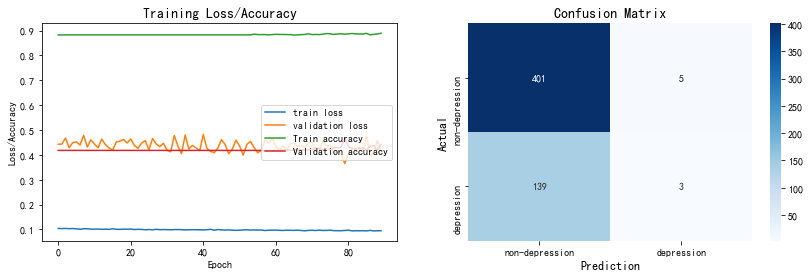

{'u04': 0.01639344262295082, 'u10': 0.0, 'u14': 0.0, 'u17': 0.0, 'u33': 0.041666666666666664, 'u35': 0.0, 'u43': 0.0, 'u44': 0.05714285714285714}
mse of score by users:  0.24024210360765735
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.00      0.00      0.00         2

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8

AC 0.75


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


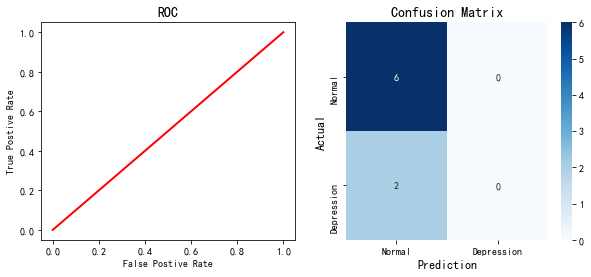

In [25]:
''' B.DNN '''

###############  Training ,prediction #################################
from keras import regularizers
from keras.layers import Dropout

epochs = 100

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer = regularizers.l2(0.01))) # input_dim = numb of features, 1D number
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu')) # regularizer in hidden layers
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))  # 5 classes
model.summary()
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc']) 
history=model.fit(X_train, y_train_dummy, epochs=epochs,validation_split=0.33, batch_size=32, verbose = 0)

y_predict = model.predict(X_test)
y_predicted = y_predict.argmax(axis = 1)

###############################################below######################################################
########### plot traing acc and loss, f1 score##########################

import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_curve
import matplotlib.pyplot as plt

y_t = y_test_dummy.argmax(axis =1)

print(classification_report(y_t,y_predicted))
print("AC",accuracy_score(y_t,y_predicted))

### plotting ####
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Training Loss/Accuracy',fontsize=14,fontweight='bold')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.plot(history.history['loss'][10:], label='Train loss')
plt.plot(history.history['val_loss'][10:], label ='Val loss')
plt.plot(history.history['acc'][10:], label='Train accuracy')
plt.plot(history.history['val_acc'][10:], label ='Val accuracy')
plt.legend(['train loss','validation loss', 'Train accuracy','Validation accuracy'], loc='center right')

#####confusion matrix#####
plt.subplot(122)
plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
ticks=['non-depression','depression']
conf_mat = confusion_matrix( y_t,y_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=ticks, yticklabels=ticks, cmap="Blues")
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)

plt.show()
########################################above###################################################################

predicted_df = pd.DataFrame(y_predicted, index =X_test.index) # dataframe of predected label + user index
predictions_temp, score_user  = classifier_slice2uid(predicted_df, trigger= trigger) # predictions output in df formate , by user id
predictions =  predictions_temp.iloc[:,-1].to_list()  # convert to array 
y_t = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list())  # pickup the associated test's depression label by user

mse = np.sum((y_t-list(score_user.values()))**2/len(y_t))

print(score_user)
print("mse of score by users: ",mse) 
print(classification_report(y_t,predictions))
print("AC",accuracy_score(y_t,predictions))

fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_t,predictions)
plt.figure(figsize=(10,4))

plt.subplot(121)

plt.title('ROC',fontsize=14,fontweight='bold')
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.plot(fpr_dnn,tpr_dnn,linewidth=2, linestyle="-",color='red')

plt.subplot(122)
ticks=['Normal','Depression']
conf_mat = confusion_matrix(y_t, predictions)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=ticks, yticklabels=ticks,cmap="Blues")
plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.show()

10. KNN
sugmentation factor = 2
feature number = 10
{'u07': 0.0, 'u09': 0.0, 'u15': 0.057971014492753624, 'u17': 0.08571428571428572, 'u20': 0.1016949152542373, 'u27': 0.09859154929577464, 'u33': 0.08333333333333333, 'u58': 0.04411764705882353}
0.000000000, 0.000000000, 0.057971014, 0.085714286, 0.101694915, 0.098591549, 0.083333333, 0.044117647, [0, 0, 0, 0, 1, 1, 0, 0]
mse of score by users:  0.21269566247614374
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.00      0.00      0.00         2

    accuracy                           0.50         8
   macro avg       0.33      0.33      0.33         8
weighted avg       0.50      0.50      0.50         8

AC 0.5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


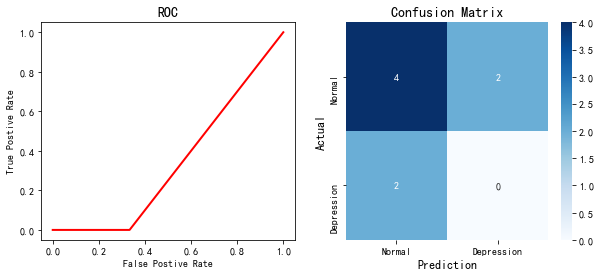

In [34]:
# Knn with stage 1+ stage2
# from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif']=[u'simHei']
matplotlib.rcParams['axes.unicode_minus']=False

# STUDENT-t
def outlier_t(data):
    n=len(data)
    mu= np.mean(data)
    S= np.std(data,ddof=1)#variance
    t_av= 1.440 #https:// 90% confidence, 1 side, en.wikipedia.org/wiki/Student%27s_t-distribution
#     t_av =0.906 # 80%
    t_av= 1.943 #  95% confidentce, 1 side
    X_left = mu-t_av*S/np.sqrt(n)
    X_right = mu +t_av*S/np.sqrt(n)
#     print(X_left,",",X_right)
    result=[]
    for i in range(len(data)):
        if data[i] >= X_right:
            result.append(1)
        else:
            result.append(0)
    return result

# ===========================machine learning algorithms to predict and plot====================#

### 10. knn Classifier 
print("=============================================================================================") 
from sklearn.neighbors import KNeighborsClassifier
print("10. KNN")
print('sugmentation factor =', agm_factor)
print('feature number =', len(col_slct))

# knn=KNeighborsClassifier(n_neighbors= 5)
# knn = KNeighborsClassifier()
# knn.fit(X_train,y_train_dummy)
# pred = knn.predict(X_test) ####
# predictions_10 = pred.argmax(axis = 1) ####

############ LR
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l2')
# clf.fit(X_train,y_train_dummy)  ####
# pred = clf.predict(X_test) ####
# predictions_2 = pred.argmax(axis = 1) ####

############# svm
# from sklearn.svm import SVC
# clf = SVC(kernel='rbf', probability=True)
# clf.fit(X_train,y_train)
# clf.fit(X_train,y_train_dummy)  ####
# pred = clf.predict(X_test) ####
# predictions_9 = pred.argmax(axis = 1) ####

from sklearn.ensemble import RandomForestClassifier
#     print("=============================================================================================")     
#     print("1. RF")

RF = RandomForestClassifier(n_estimators=10,oob_score= True) # after tuning, n_estimators =100 is too large
RF.fit(X_train,y_train_dummy) ###
pred = RF.predict(X_test) ####
predictions_10 = pred.argmax(axis = 1) ####

predicted_df = pd.DataFrame(predictions_10, index =X_test.index) 
predictions_temp, score_user_10  = classifier_slice2uid(predicted_df, trigger= trigger) 
# predictions_10 =  predictions_temp.iloc[:,-1].to_list() 

predictions_10 = outlier_t(list(score_user_10.values()))
y_test = np.array(phq.loc[list(predictions_temp.index),"dp_class"].to_list()) 
mse_10 = np.sum((y_test-list(score_user_10.values()))**2/len(y_test))

print(score_user_10)
for value in score_user_10.values():
    print('%.9f, '%value, end='')
print(predictions_10)
print("mse of score by users: ",mse_10)
print(classification_report(y_test,predictions_10))
print("AC",accuracy_score(y_test,predictions_10))

####################### Plot ############################
fpr_10, tpr_10, thresholds_10 = \
roc_curve(y_test,predictions_10)
plt.figure(figsize=(10,4))

plt.subplot(121)
# plt.xlim(0,1) 
# plt.ylim(0.0,1.1) 
plt.title('ROC',fontsize=14,fontweight='bold')
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.plot(fpr_10,tpr_10,linewidth=2, linestyle="-",color='red')

plt.subplot(122)
ticks=['Normal','Depression']
conf_mat = confusion_matrix(y_test, predictions_10)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=ticks, yticklabels=ticks,cmap="Blues")
plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.show()


In [19]:
###################### ONLY for DNN experiment to find aug factor: ##############################
##############  output: array of factor+ predicted probability list by user_test+ trueth list + mse  ############
############### this section follows the function defination sections(before data process section)  ###############



''' B.DNN '''
import time
###############  Training ,prediction #################################
def dnn_predict_score_user(X_train, y_train_dummy, epochs):
    epochs = epochs

    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu')) # input_dim = numb of features, 1D number
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))  # 5 classes
#     model.summary()
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc']) 
    history=model.fit(X_train, y_train_dummy, epochs=epochs,validation_split=0.33, batch_size=32, verbose = 0)

    y_predict = model.predict(X_test)
    y_predicted = y_predict.argmax(axis = 1)
    y_t = y_test_dummy.argmax(axis =1)

    predicted_df = pd.DataFrame(y_predicted, index =X_test.index) # dataframe of predected label + user index
    predictions_temp, score_user  = classifier_slice2uid(predicted_df, trigger= trigger) # predictions output in df formate , by user id
    predictions =  predictions_temp.iloc[:,-1].to_list()  # convert to array 
    y_t = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list())  # pickup the associated test's depression label by user
    mse = np.sum((y_t-list(score_user.values()))**2/len(y_t))
    return score_user, y_t, mse


#############  pick up features， see what's picked in ML algorithm portion ###########################


# 0. all features
col_slct= full_col # ALL features, 78 cols after manully filter "null" and "green" columns

# # 1. EMA 6 + sensing 4
col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate',
            'dark_duration(sec)','audio_ audio inference',
#             'phonecharge_duration(sec)','activity_ activity inference'] 

# # # 2. EMA  6 features
# col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate']

# # # # 3. sensing 4 features
# col_slct=['dark_duration(sec)','audio_ audio inference',
#           'phonecharge_duration(sec)','activity_ activity inference'] 


''' Data processing 1:
    - select columns
    - normalization
    - PCA (on demand)
'''

dataset_col = dataset[col_slct]

data_norm= minmax_normalize(dataset_col)
data_norm=data_norm.fillna(0) # choose -1 or 0

## process PCA ############
# dataset_np = data_norm.iloc[:,1:].to_numpy()  # transfer to numpy without index of 'user_date'
# K=2
# dataset_np=PCA(dataset_np, K, axis= 1)
# dataset_np.shape
# dataset_pca=pd.DataFrame(dataset_np, columns= np.arange(K), index= data_norm.index)


# print("Below is data_norm:")
# data_norm

''' Data processing 2:
    - add lables
    - clean data
    '''


########### 1.2 add label(dp_class) by merging phq ###############
########## add uer and set as index for merging phq ###########


# dataset_1=dataset   # no pca, no normalization
dataset_1 = data_norm # with normalization , no pca
# dataset_1= dataset_pca # with both normalization + pca

dataset_1['user']=dataset_1.index  # copy 'user' column with index values
def str_slice(str):
    return str[:3]
dataset_1['user']=dataset_1['user'].apply(str_slice)
dataset_1 = dataset_1.reset_index().set_index('user') 
dataset_1 = dataset_1.drop(['user_date'], axis=1)# keep the index columns and set 'user' col as index
# dataset_1.fillna(0, inplace= True)
print("Dataset before labeling is:", dataset_1.shape)

## add label of dp_class
dp_class_list=[]
for user in dataset_1.index: 
    if user in phq_selected.index.to_list():
        dp_class_list.append(phq_selected.loc[user]['dp_class_y'])
    else:
        dp_class_list.append(None) # for removing those users are not in the selected list
dataset_1['dp_class']=dp_class_list

dataset_1= dataset_1.dropna() #dataset_1= dataset_1.dropna(how='all')  will cause big issue
dataset_1= dataset_1.fillna(0)

# dataset_2 = minmax_normalize(dataset_1)
print("After labeling and removing non-completed label, dataset shape is:", dataset_1.shape)

''' Data processing 3:
    - Split training and testing dataset
    - Data augment : pick the id with depression ,which stays in train dataset for augmenting'''

# process training and testing data ########
random.seed(seed_value)  # 1 depression :42, 0 ,3 ; 0 depression: 2,5, 6. see what's in ML portion
trigger =0.2 # threshold for 2nd round classification
dataset_full= dataset_1 #11/15 after norm
id_list =list(np.unique(dataset_full.index))
split = int(0.8*len(id_list))


id_train= sorted(random.sample(id_list,split))
id_test= sorted(list(set(id_list)- set(id_train)))

id_dptrain=[]
id_alldepression=['u17', 'u18','u23','u33','u52'] # users who has depression
for id in id_alldepression:
    if (id in id_train):
        id_dptrain.append(id)  #add to augment id list for depression id in train dataset
# print(id_dptrain)
###############  start iteration ###################
import time

p_dnn =  pd.DataFrame()
# nondepression_idnum_train=len(np.unique(y_train.index))-len(id_dptrain) # none depression id number in training
nondepression_idnum_train=len(np.unique(y_train.index))

for j in range(nondepression_idnum_train):       
    p_temp=[]    
    
    agm_factor = j # add 4 times depressed user data, randomly        
    id_augment = []
    # for i in range(len(id_dptrain)* agm_factor): # add 4X users with depression 
    for i in range(agm_factor): # add users in train dataset with depression     
        id_augment.append(random.sample(id_dptrain,1)[0])

    id_agm =id_train+id_augment
    random.shuffle(id_agm)

    X_train= dataset_1.loc[id_agm,:].iloc[:,:-1] # X_train shape[0] will increase after augmenting
    y_train= dataset_1.loc[id_agm,:].iloc[:,-1]
#     print("id_augment", id_agm)

    X_test= dataset_1.loc[id_test,:].iloc[:,:-1]
    y_test= dataset_1.loc[id_test,:].iloc[:,-1]
    y_train_dummy = pd.get_dummies(y_train).values
    y_test_dummy = pd.get_dummies(y_test).values

    score_user, y_t, mse = dnn_predict_score_user(X_train, y_train_dummy, 200) # train and predict with CNN ================
    p_temp.append(int(time.time()))
    p_temp.append(j)
    p_temp.extend(list(score_user.values()))
    p_temp.extend(y_t)
    p_temp.append(mse)
    p_temp.append(entropy(list(score_user.values())))
    p_temp.append("DNN")
    p_temp.append(len(col_slct))
    p_temp.append(seed_value)
#     print("score by user", score_user)
#     print("yt",y_t)
#     print("mse",mse)
    
    p_series =  pd.Series(p_temp)
    p_dnn = p_dnn.append(p_series, ignore_index=True)
p_col = ["time","aug_factor"]+list(score_user.keys())*2+["mse","entropy","model","feature num","random seed"]
p_dnn.columns= p_col
p_dnn['feature num']=p_dnn['feature num'].astype(int) #format the feature type
p_dnn['aug_factor']=p_dnn['aug_factor'].astype(int)
# p_dnn.to_csv(dir_data+""entropy_probability.csv")
p_dnn.to_csv(dir_data+"entropy_probability.csv", mode="a")
print("DNN entropy report saved:", dir_data)

,time,aug_factor,u00_prob,u05_prob,u09_prob,u16_prob,u27_prob,u42_prob,u49_prob,u52_prob,...,u16gth,u27gth,u42gth,u49gth,u52gth,mse,entropy,model,feature num,random seed
0,1.662599e+09,0,0.013793,0.029851,0.000000,0.089552,0.140845,0.014493,0.072464,0.028169,...,1.0,0.0,0.0,0.0,1.0,0.224969,2.375875,RF,10,42.0
1,1.662599e+09,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.250000,0.000000,LR,10,42.0
2,1.662599e+09,0,0.062069,0.194030,0.101449,0.253731,0.281690,0.173913,0.217391,0.126761,...,1.0,0.0,0.0,0.0,1.0,0.191014,2.874400,DT,10,42.0
3,1.662599e+09,0,0.013793,0.000000,0.014493,0.104478,0.056338,0.014493,0.072464,0.014085,...,1.0,0.0,0.0,0.0,1.0,0.222878,2.342320,GBDT,10,42.0
4,1.662599e+09,0,0.006897,0.014925,0.000000,0.104478,0.084507,0.014493,0.043478,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.226434,2.074218,AB,10,42.0
5,1.662599e+09,0,0.041379,0.000000,0.000000,0.313433,0.098592,0.043478,0.231884,0.028169,...,1.0,0.0,0.0,0.0,1.0,0.185365,2.075278,GNB,10,42.0
6,1.662599e+09,0,0.006897,0.000000,0.000000,0.059701,0.000000,0.000000,0.000000,0.014085,...,1.0,0.0,0.0,0.0,1.0,0.232030,1.064389,LDA,10,42.0
7,1.662599e+09,0,0.048276,0.029851,0.000000,0.343284,0.154930,0.043478,0.217391,0.042254,...,1.0,0.0,0.0,0.0,1.0,0.178116,2.289864,QDA,10,42.0
8,1.662599e+09,0,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,0.014493,0.014085,...,1.0,0.0,0.0,0.0,1.0,0.246555,1.584831,SVM,10,42.0
9,1.662599e+09,0,0.020690,0.029851,0.014493,0.059701,0.098592,0.101449,0.115942,0.084507,...,1.0,0.0,0.0,0.0,1.0,0.219659,2.734879,KNN,10,42.0
